# Combining two images using homography matrix to account for difference in perspective.

## Load data

In [ ]:
%matplotlib inline
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import scipy as sp

In [ ]:
im1 = cv2.imread("book.jpg")
im2 = cv2.imread("cat.jpg")

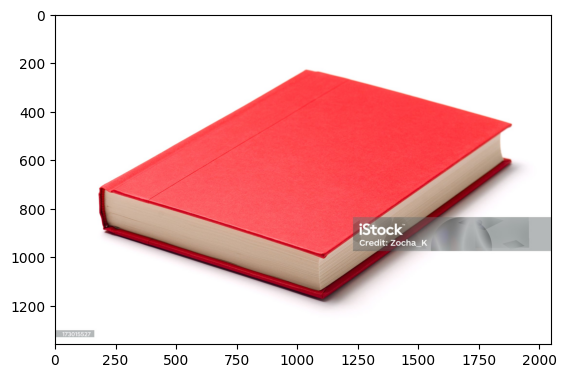

In [ ]:
plt.imshow(cv2.cvtColor(im1,cv2.COLOR_BGR2RGB))

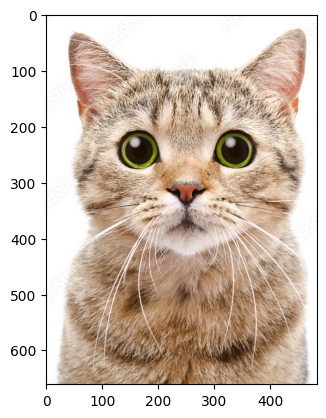

In [ ]:
plt.imshow(cv2.cvtColor(im2,cv2.COLOR_BGR2RGB))

## Pick manually 4 corresponding points

In [ ]:
im1_pts = np.array([[1035, 228],[1883, 453],[1105, 988],[188, 713]])
im2_pts = np.array([[0,0],[im2.shape[1] - 1, 0],[im2.shape[1] - 1,im2.shape[0] - 1], [0, im2.shape[0] - 1]])

## Find homography in 3 ways: built-in OpenCV function, SVD and Eigenvalue approach

### OpenCV built-in function

In [ ]:
 H, status = cv2.findHomography(im2_pts, im1_pts) # im1_pts ~ H * im2_pts
 H

array([[ 1.60698264e+00, -1.31398544e+00,  1.03500000e+03],
       [ 4.30062590e-01,  6.18598743e-01,  2.28000000e+02],
       [-7.89755402e-05, -1.63043116e-04,  1.00000000e+00]])

### SVD

In [ ]:
def get_mat_for_point(u, v):
  a1 = np.array([v[0], v[1], 1])
  a2 =  np.zeros(3)
  b1 = np.concatenate((- a1[np.newaxis, :], a2[np.newaxis, :]), axis = 0)
  b2 = np.concatenate((a2[np.newaxis, :], - a1[np.newaxis, :]), axis = 0)
  b3 = np.concatenate((u[0]*a1[np.newaxis, :], u[1]*a1[np.newaxis, :]), axis = 0)
  return np.concatenate((b1,b2,b3), axis = 1)

In [ ]:
A = None
for p1,p2 in zip(im1_pts, im2_pts):
  temp = get_mat_for_point(p1, p2)
  if A is None:
    A = temp
  else:
    A = np.concatenate((A, temp), axis = 0)

In [ ]:
U, s, Vh = sp.linalg.svd(A) # last row of Vh is our homography matrix

In [ ]:
H_svd = Vh[-1].reshape(3,3)
H_svd /= H_svd[2,2] # normalization

In [ ]:
H_svd

array([[ 1.60698264e+00, -1.31398544e+00,  1.03500000e+03],
       [ 4.30062590e-01,  6.18598743e-01,  2.28000000e+02],
       [-7.89755403e-05, -1.63043116e-04,  1.00000000e+00]])

### Eigenvalue problem for the matrix A.T@A

In [ ]:
eigval, eigvec = np.linalg.eig(A.T@A)

In [ ]:
H_eig = eigvec[:, np.argmin(np.abs(eigval))].reshape(3,3)
H_eig /= H_eig[2,2]

In [ ]:
eigval, eigvec = np.linalg.eig(np.concatenate((A, np.zeros((1,9))), axis  =  0))

In [ ]:
np.real(eigval)

array([ 4.69354409e+05,  1.02463795e+04, -9.01023421e+03, -4.88104073e+02,
        2.24542063e+01,  2.24542063e+01, -2.61792228e+01, -2.61792228e+01,
        0.00000000e+00])

In [ ]:
j = np.argmin(np.abs(eigval))
j

4

In [ ]:
np.real(eigvec[j]).reshape(3,3)

array([[ 6.75949047e-01,  4.92297113e-01, -4.15024244e-01],
       [ 4.61466414e-03, -2.15662842e-02, -2.15662842e-02],
       [-2.19787295e-02, -2.19787295e-02,  5.83683760e-04]])

### Compare homography matrices found  by different methods

In [ ]:
np.allclose(H, H_svd)


True

In [ ]:
np.allclose(H, H_eig)

True

## Warping image and mask

warping cat image

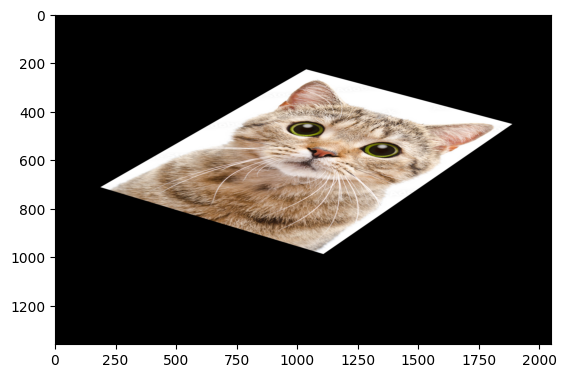

In [ ]:
im_out = cv2.warpPerspective(im2, H, (im1.shape[1],im1.shape[0])) # im_out ~ H * im2
plt.imshow(cv2.cvtColor(im_out,cv2.COLOR_BGR2RGB))

mask warping

In [ ]:
mask = np.ones(im2.shape, dtype = "uint8")
mask_out = cv2.warpPerspective(mask, H, (im1.shape[1],im1.shape[0]))

## Blend images using mask

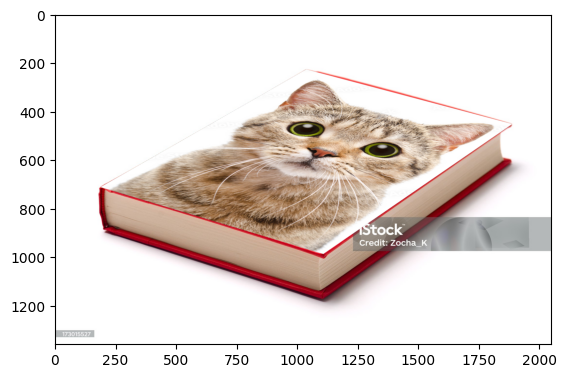

In [ ]:
im_res = im1 * (1 - mask_out ) + im_out*mask_out
plt.imshow(cv2.cvtColor(im_res,cv2.COLOR_BGR2RGB))